In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
from matplotlib.pyplot import figure
from transformers import Trainer, TrainingArguments
from sklearn.metrics import classification_report, f1_score


## Import Data and Separate into Text and Labels

In [17]:
# Import train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Separate train labels and text
train_labels = train['category']
train_text = train['text']

# Separate test labels and text
test_labels = test['category']
test_text = test['text']

In [20]:
train_labels.value_counts()

category
card_payment_fee_charged                            187
direct_debit_payment_not_recognised                 182
balance_not_updated_after_cheque_or_cash_deposit    181
wrong_amount_of_cash_received                       180
cash_withdrawal_charge                              177
                                                   ... 
lost_or_stolen_card                                  82
card_swallowed                                       61
card_acceptance                                      59
virtual_card_not_working                             41
contactless_not_working                              35
Name: count, Length: 77, dtype: int64

## Identify number of occurances in each category in the train dataset


In [21]:
# Identify unique categories
unique_categories = set(test_labels)

# Create dictionary of unique categories as keys, and initialized with 0 as values
unique_categories = dict.fromkeys(unique_categories, 0)

# Count number of occurances of each category
for category in test_labels:
    unique_categories[category] +=1

In [22]:
# Sort categories in descending order
sorted_categories = sorted(unique_categories.items(), key=lambda x:x[1], reverse = True)

# Convert resulting list back into dictionary
unique_categories_sorted = dict(sorted_categories)

# Print sorted categories with their associated values
print(unique_categories_sorted)

{'contactless_not_working': 40, 'card_payment_not_recognised': 40, 'balance_not_updated_after_cheque_or_cash_deposit': 40, 'card_swallowed': 40, 'exchange_rate': 40, 'pending_cash_withdrawal': 40, 'wrong_amount_of_cash_received': 40, 'get_physical_card': 40, 'getting_virtual_card': 40, 'top_up_failed': 40, 'order_physical_card': 40, 'transfer_into_account': 40, 'wrong_exchange_rate_for_cash_withdrawal': 40, 'pin_blocked': 40, 'card_about_to_expire': 40, 'top_up_by_bank_transfer_charge': 40, 'top_up_by_card_charge': 40, 'transfer_fee_charged': 40, 'balance_not_updated_after_bank_transfer': 40, 'card_payment_wrong_exchange_rate': 40, 'change_pin': 40, 'disposable_card_limits': 40, 'get_disposable_virtual_card': 40, 'transaction_charged_twice': 40, 'exchange_via_app': 40, 'direct_debit_payment_not_recognised': 40, 'activate_my_card': 40, 'card_delivery_estimate': 40, 'lost_or_stolen_card': 40, 'topping_up_by_card': 40, 'failed_transfer': 40, 'card_acceptance': 40, 'why_verify_identity': 4

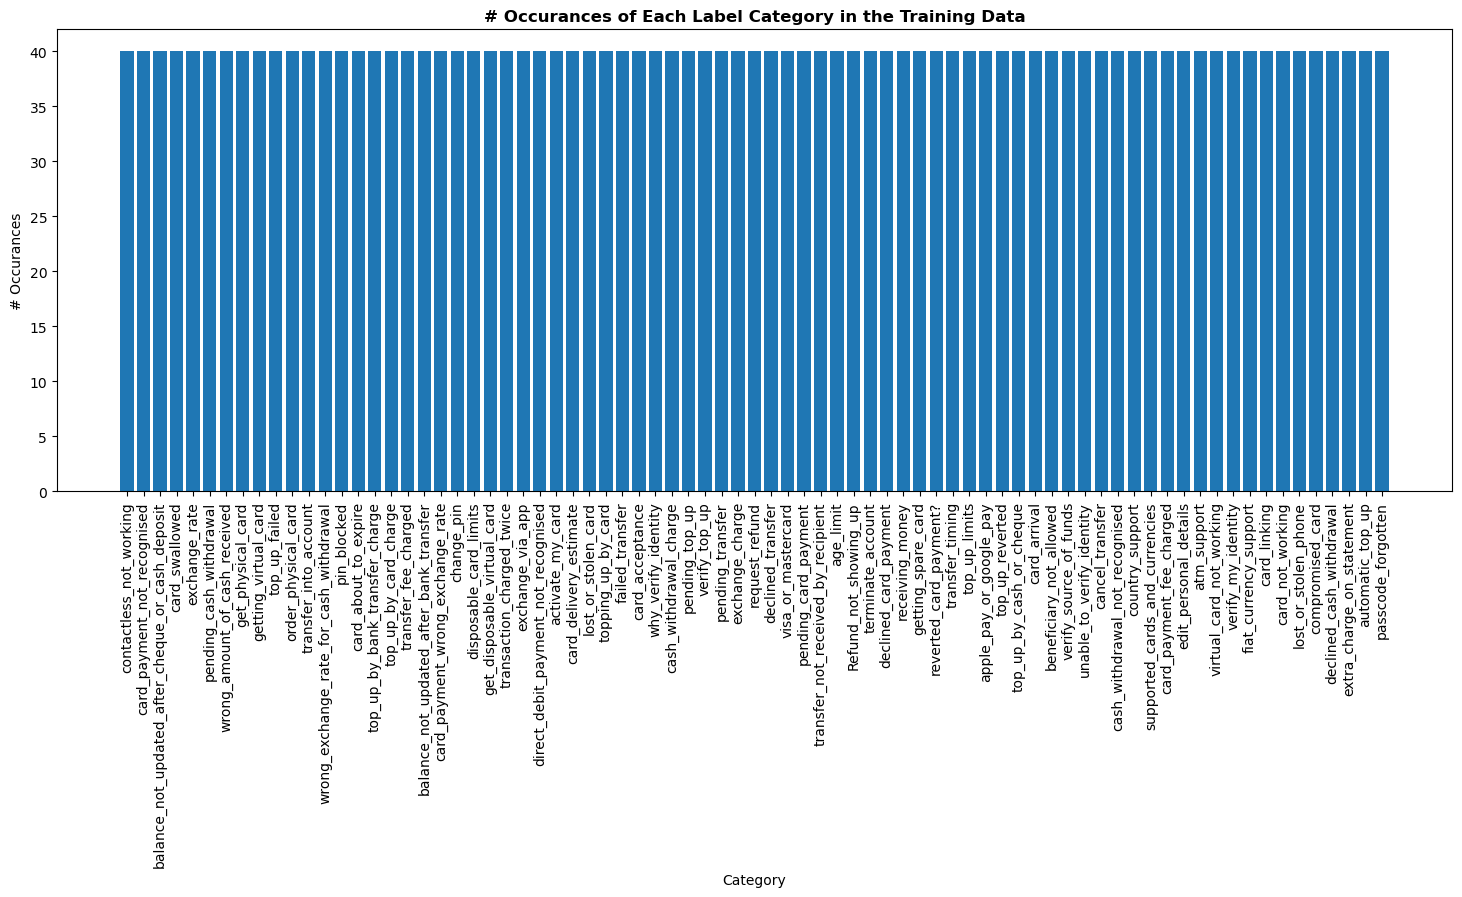

In [23]:
# Create lists of categories and their values
categories = list(unique_categories_sorted.keys())
values = list(unique_categories_sorted.values())

# Create a new figure
plt.figure(figsize=(18, 6))
plt.title('# Occurances of Each Label Category in the Training Data', fontweight = 'bold')
plt.ylabel('# Occurances')
plt.xlabel('Category')
plt.xticks(rotation=90)

# Create the bar plot
plt.bar(categories, values)

# Show the plot
plt.show()

## Train the Model

In [6]:
# Convert the Series into a list of strings
train_text_string_list = train_text.tolist()
test_text_string_list = test_text.tolist()

In [7]:
model_id = 'philschmid/BERT-Banking77'

# This is the maximum number of tokens in any document sent to BERT.
max_length = 512

# Create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Tokenize texts
tokenized_texts = tokenizer(train_text_string_list, truncation=True, padding=True, return_tensors="pt")

# Create labels
unique_labels = set(label for label in train_labels)
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}

# Load pre-trained BERT model
model = AutoModelForSequenceClassification.from_pretrained(model_id)

# Encoding texts and labels for tokenizer
train_encodings = tokenizer(train_text_string_list, truncation=True, padding=True, max_length=max_length)
test_encodings  = tokenizer(test_text_string_list, truncation=True, padding=True, max_length=max_length)

train_labels_encoded = [label2id[y] for y in train_labels]
test_labels_encoded  = [label2id[y] for y in test_labels]

In [8]:
# Convert encoded texts and labels into a dataset object
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MyDataset(train_encodings, train_labels_encoded)
test_dataset = MyDataset(test_encodings, test_labels_encoded)

In [9]:
# Set training parameters
training_args = TrainingArguments(
    num_train_epochs=28,              # total number of training epochs
    per_device_train_batch_size=15,  # batch size per device during training
    per_device_eval_batch_size=12,   # batch size for evaluation
    learning_rate=1e-5,              # initial learning rate for Adam optimizer
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,               # number of steps to output logging (set lower because of small dataset size)
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

In [10]:
# Evaluation function that returns F1 score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  #score = accuracy_score(labels, preds)
  score = f1_score(labels, preds, average='weighted')
  return {
      'f1': score,
  }

In [11]:
# Create HuggingFace Trainer Object
trainer = Trainer(
    model = model,          # the instantiated 🤗 Transformers model to be trained
    args = training_args,                  # training arguments, defined above
    train_dataset = train_dataset,         # training dataset
    eval_dataset = test_dataset,     # evaluation dataset
    compute_metrics = compute_metrics      # our custom evaluation function
)

In [12]:
# Train the model
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/wally/anaconda3/envs/INFO4900/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/18676 [00:00<?, ?it/s]

{'loss': 8.1878, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}


  0%|          | 0/257 [00:00<?, ?it/s]

NameError: name 'f1_score' is not defined

In [ ]:
# Predict results based on Validation Dataset
predicted_results = trainer.predict(test_dataset)
predicted_labels = predicted_results.predictions.argmax(-1) # Get the highest probability prediction
predicted_labels = predicted_labels.flatten().tolist()      # Flatten the predictions into a 1D list
predicted_labels = [id2label[l] for l in predicted_labels]  # Convert from integers back to strings for readability

In [ ]:
# set device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

# put model on GPU (is done in-place)
model.to(device)

# List to store predicted probabilities
predicted_probabilities = []

# Iterate through each sentence and its ground truth label
incorrect_predictions = []

# Iterate through each sentence
for sentence in test['text']:
    # Tokenize sentence
    encoding = tokenizer(sentence, max_length=512, truncation=True, padding='max_length', return_tensors='pt')

    # Move input tensors to GPU if available
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

     # Get labels and probabilities pairs, sort them in descending order of probability
    label_prob_pairs = [(model.config.id2label[i], prob) for i, prob in enumerate(probabilities)]
    label_prob_pairs.sort(key=lambda x: x[1], reverse=True)

    # Append to predicted probabilities list
    predicted_probabilities.append(label_prob_pairs)

In [22]:
# Output the predicted probability scores for all label possibilities
for i, sentence in enumerate(test['text']):
    print("Sentence:", sentence)
    print("Predicted Probabilities:")
    for label, prob in predicted_probabilities[i]:
        print(f"{label}: {prob}")
    print()

,text
0,I am still waiting on my card?
1,What can I do if my card still hasn't arrived ...
2,I have been waiting over a week. Is the card s...
3,Can I track my card while it is in the process...
4,"How do I know if I will get my card, or if it ..."
...,...
9998,You provide support in what countries?
9999,What countries are you supporting?
10000,What countries are getting support?
10001,Are cards available in the EU?


In [ ]:
# Output the incorrect predictions
for idx, (sentence, predicted_labels) in enumerate(zip(test['text'], predicted_probabilities)):
    true_labels = test['category'].iloc[idx]

    # Compare predicted labels with true labels
    if predicted_labels != true_labels:
        print("Sentence:", sentence)
        print("True Labels:", true_labels)
        print("Top Predicted Label:", predicted_labels[0])
